# SWANA Census analysis

By [Ellis Simani](https://twitter.com/emsimani) and [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

This analysis was conducted for the March 28, 2019, Los Angeles Times story ["Are Arabs and Iranians white? Census says yes, but many disagree"](https://www.latimes.com/projects/la-me-census-middle-east-north-africa-race/).

It found roughly 3 million people of Southwest Asian, Middle Eastern or North African descent live in the United States. No county is home to more of these communities than Los Angeles, where more than 350,000 people can trace their roots to a region that stretches from Mauritania to the mountains of Afghanistan. In past census surveys, more than 80% in this group have called themselves white.

Here's how we did it:

### Import Python tools

In [87]:
import warnings
import pandas as pd
import altair as alt
import altair_latimes as lat

In [88]:
warnings.simplefilter("ignore")

In [89]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

### How many people of these ancestries live in the United States?

Doing this requires analysis of the ancestry question asked by the American Community Survey. To come to our answer, we will consult several different sources.

First, we look to the Census itself. As part of its [2015 National Content Test Race and Ethnicity Analysis Report](https://www2.census.gov/programs-surveys/decennial/2020/program-management/final-analysis-reports/2015nct-race-ethnicity-analysis.pdf) it estimated the population of people from the Middle East and North Africa (MENA) at 3.1 million.

<img src="input/census-mena-estimate.png">

Next, we consult the table B04006 from the American Community Survey, which Census officials recommended for this analysis. The agency has also recent used this table itself to report on [the number of Irish Americans](https://www.census.gov/newsroom/facts-for-features/2017/cb17-ff05.html).

In [90]:
acs_B04006_data = pd.read_csv("./input/ACS_17_1YR_B04006_with_ann.csv")

The ACS ancestry totals records are filtered down to the subset of ancestries that correspond to the description of the MENA group developed in the Census report.

In [91]:
acs_ancestry_codes = pd.read_csv("./input/acs_ancestry_codes.csv")

In [92]:
acs_mena_codes = acs_ancestry_codes[acs_ancestry_codes.mena]

In [93]:
print("{:,d}".format(acs_B04006_data[list(acs_mena_codes.field)].sum(axis=1)[0]))

2,722,452


In the story we also refer to a slightly wider group of ancestries that including people from countries that neighbor the Middle East, like Afghanistan, Armenia and Turkey. This group is sometimes described as SWANA, referring to Southwest Asia and North Africa. What are the ACS totals if we cast the net wider to include those ancestries?

In [94]:
acs_swana_codes = acs_ancestry_codes[acs_ancestry_codes.swana]

In [95]:
print("{:,d}".format(acs_B04006_data[list(acs_swana_codes.field)].sum(axis=1)[0]))

3,793,489


Finally, we will look to the IPUMS microdata, which provides a wider set of ancestries provided by 5% of respondants who have their complete questionarre released. This provides the possibility of more precision, but is limited to the answers entered on the first of two boxes that follow the question.

In [96]:
ipums_ancestry_data = pd.read_csv("input/ipums.csv")

In the same manner as the ACS data, the ancestry codes in the IPUMS data must be restricted to the countries of origin that we are studying. Again, we're collected them all from the source and coded them based on whether they qualify for our work.

In [97]:
ipums_ancestry_codes = pd.read_csv("./input/ipums_ancestry_codes.csv")

In [98]:
ipums_mena_codes = ipums_ancestry_codes[ipums_ancestry_codes.mena]

In [99]:
ipums_mena_data = ipums_ancestry_data[ipums_ancestry_data.ancestry_code.isin(ipums_mena_codes.ancestry_code)]

In [100]:
print("{:,d}".format(ipums_mena_data.total.sum()))

2,290,654


Lets do the same for the wider SWANA group.

In [101]:
ipums_swana_codes = ipums_ancestry_codes[ipums_ancestry_codes.swana]

In [102]:
ipums_swana_data = ipums_ancestry_data[ipums_ancestry_data.ancestry_code.isin(ipums_swana_codes.ancestry_code)]

In [103]:
print("{:,d}".format(ipums_swana_data.total.sum()))

3,241,727


With these slight variations between the totals, depending on the source, we decided to describe this group by saying "roughly 3 million people of Southwest Asian, Middle Eastern or North African descent live in the United States."

### Which race do people in this group claim?

We can investigate this question by returning the IPUMS microdata, which includes a crosstab of each ancestry group with the question each respondant gave to the question asking their race. To simplify the analysis, we will look at what percentage of people in this group, when confronted with the Census Bureau's limited menu of races, have called themselves white.

First for the narrow MENA group.

In [104]:
print("{:.2f}".format(ipums_mena_data.white_count.sum() / float(ipums_mena_data.total.sum())))

0.89


Then for the broader SWANA group.

In [105]:
print("{:.2f}".format(ipums_swana_data.white_count.sum() / float(ipums_swana_data.total.sum())))

0.82


Let's chart that to see the variation between ancestries.

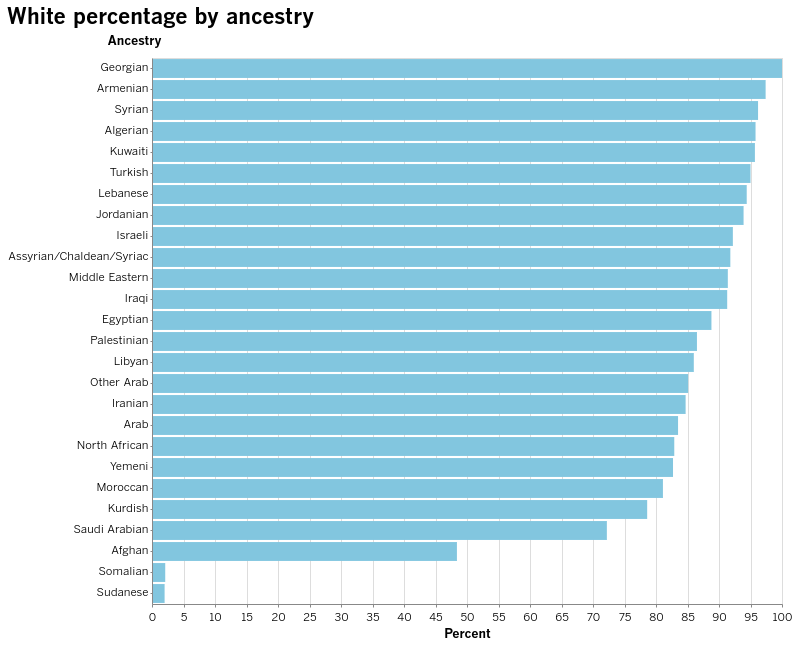

In [106]:
alt.Chart(ipums_swana_data.sort_values("total", ascending=False)).mark_bar().encode(
    x=alt.X(
        "white_percent:Q",
        title="Percent"
    ),
    y=alt.Y(
        "ancestry_name:N",
        title="Ancestry",
        sort=alt.EncodingSortField(field="white_percent", op="sum", order="descending")
    )
).properties(
    width=630,
    title="White percentage by ancestry"
)

Because the overall denominator we selected as our answer to the first question in this notebook includes the more expansive SWANA group, and in the interest of being conservative in our analysis, we decided its percentage figure in our story, despite the fact that a more restrictive definition like MENA would boost the figure. We reported that, "more than 80% in this group have called themselves white."

### How many people in this group live in Los Angeles County?

We ran a similar cut from the IPUMS microdata, this time limited the results to Los Angeles County.

In [107]:
ipums_la_ancestry_data = pd.read_csv("input/ipums-LA.csv")

Again we will filter to our target ancestries. We will skip straight to the broader SWANA definition that answered the questions above.

In [108]:
ipums_la_swana_data = ipums_la_ancestry_data[ipums_la_ancestry_data.ancestry_code.isin(ipums_swana_codes.ancestry_code)]

Let's sum the total

In [109]:
print("{:,d}".format(ipums_la_swana_data.total.sum()))

356,633


As recommended by staff at IPUMS, we decided to compare counties by consulting another data set: The NHGIS geospatial database. It provides ancestry totals by county.

In [110]:
nhgis_ancestry_data = pd.read_csv("input/nhgis0003_ds234_20175_2017_county_clean.csv")

Just like the ACS and IPUMS data, the NHGIS dataset has its own unique set of codes for describing ancestry answers. Again, we decoded them so we could limit the data to the group we're studying.

In [111]:
nhgis_swana_codes = {
  "AH8TE002": "Afghan",
  "AH8TE007": "Arab Egyptian",
  "AH8TE008": "Arab Iraqi",
  "AH8TE009": "Arab Jordanian",
  "AH8TE010": "Arab Lebanese",
  "AH8TE011": "Arab Moroccan",
  "AH8TE012": "Arab Palestinian",
  "AH8TE013": "Arab Syrian",
  "AH8TE014": "Arab Arab",
  "AH8TE015": "Arab Other Arab",
  "AH8TE016": "Armenian",
  "AH8TE017": "Assyrian/Chaldean/Syriac",
  "AH8TE082": "Subsaharan African Somali",
  "AH8TE050": "Israeli",
  "AH8TE048": "Iranian",
  "AH8TE091": "Turkish"
}

We will use those to filter and trim the data to only what we need.

In [112]:
nhgis_metadata = [
    'AH8TE001',
    'GISJOIN',
    'YEAR',
    'STATE',
    'STATEA',
    'COUNTY',
    'COUNTYA',
    'NAME_E',
]

In [113]:
nhgis_swana_data = nhgis_ancestry_data[nhgis_metadata + list(nhgis_swana_codes.keys())]

The unique identifier of each county, the FIPS code, needs a little cleaning.

In [114]:
nhgis_swana_data['GEOID'] = nhgis_swana_data['GISJOIN'].str.slice(1,3) + nhgis_swana_data['GISJOIN'].str.slice(4,7)

Now we will calculate the SWANA total for each county using the ancestry codes.

In [115]:
nhgis_swana_data['swana'] = nhgis_swana_data[list(nhgis_swana_codes.keys())].sum(axis=1)

And decode the column names so we can read them.

In [116]:
nhgis_swana_data.rename(
    columns=nhgis_swana_codes,
).rename(
    columns={"AH8TE001": "Total"},
    inplace=True
)

To make sure we're in the ballpark of our early estimates, let's proof the nationwide SWANA total from this dataset.

In [117]:
print("{:,d}".format(nhgis_swana_data.swana.sum()))

3,616,149


In [118]:
nhgis_swana_data[
    ['GEOID', 'STATE', 'COUNTY', 'swana']
].sort_values("swana", ascending=False).head(10)

,GEOID,STATE,COUNTY,swana
204,06037,California,Los Angeles County,389905
1312,26163,Michigan,Wayne County,102350
610,17031,Illinois,Cook County,101300
215,06059,California,Orange County,92354
222,06073,California,San Diego County,84065
1851,36047,New York,Kings County,63800
1293,26125,Michigan,Oakland County,56407
2848,51059,Virginia,Fairfax County,54953
1280,26099,Michigan,Macomb County,54799
2623,48201,Texas,Harris County,53402


Because the NGHIS total for Los Angeles County is slightly higher than the IPUMS story, we decided to describe the population as "more than 350,000 people \[who\] can trace their roots to a region that stretches from Mauritania to the mountains of Afghanistan."

Since New York City is divided into different counties, let's add them up to see if where the combined area would rank.

In [119]:
nyc = [
    'New York County',
    'Bronx County',
    'Kings County',
    'Queens County',
    'Richmond County'
]

In [120]:
nhgis_swana_data[
    (nhgis_swana_data.STATE == 'New York') &
    (nhgis_swana_data.COUNTY.isin(nyc))
].sort_values("swana", ascending=False).swana.sum()

163165

Having established that, we decided it was fair to say, "No county is home to more of these communities than Los Angeles."